# Broadcasting in mumpy

## Requirements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

## Motivation

numpy compute quite efficiently over arrays, but indexing is quite slow.  So `for` loops over indices should be avoided if possible. numpy has quite a number of tricks up its sleave to help you achieve this.  Broadcasting of arrays is one such.

Consider the following motivating example.  You have a collection of $P$ images, each of which is $M \times N$ pixels.  The images are grayscale, so each pixel is represented by a single value.
The images are stored in a $P \times M \times N$-dimensional array.

Now you may want to do a number of operations on these images.
* Change the brightness of these images individually.
* Apply the same mask to all of the images.
* Darken the upper and lower edge of all the images.
* Darken the left and right edge of all the images.

It is of course easy to implement each of those operations using `for` loops, but that might not be the optimal approach.  Using numpy's broadcasting feature reduces the number of lines of code to write and can give you better performance.

## Broadcasting a scalar

Broadcasting is a central concept in numpy.  It works for all arithmetic operations `+`, `-`, `*`, `/`, `//`, `**`.

A trivial example is given below. 

In [2]:
A = np.arange(0.0, 24.0, 1.0).reshape((4, -1))
c = 10.0

In [3]:
c*A

array([[  0.,  10.,  20.,  30.,  40.,  50.],
       [ 60.,  70.,  80.,  90., 100., 110.],
       [120., 130., 140., 150., 160., 170.],
       [180., 190., 200., 210., 220., 230.]])

Each element of the array `A` has been multiplied by the value of `b`.

Conceptually, you can view this as if an array `B` were constructed where all elements are equal to `b` and the shape of `B` is identical to that of `A`.

## Broadcasting 1D array

### Over a 2D array

Things get more interesting when you broadcast a one-dimensional array over a two-dimensional array

In [4]:
A = np.arange(0.0, 24.0, 1.0).reshape((4, -1))
v = np.arange(1.0, 7.0, 1.0)

In [5]:
A, v

(array([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 16., 17.],
        [18., 19., 20., 21., 22., 23.]]),
 array([1., 2., 3., 4., 5., 6.]))

#### Axis 1

In [6]:
v + A

array([[ 1.,  3.,  5.,  7.,  9., 11.],
       [ 7.,  9., 11., 13., 15., 17.],
       [13., 15., 17., 19., 21., 23.],
       [19., 21., 23., 25., 27., 29.]])

The last, or right-most dimension of the arrays `A` and `B` must match.  Just like in the scalar case, it is as if a two-dimensional array `B` has been constructured such that each of its rows has the values of `v`, and the shape of `B` is that of `A`.

#### Axis 0

Of course, you might want to broadcast a vector over the columns of the two-dimensional array rather than its rows.

In [7]:
A = np.arange(0.0, 24.0, 1.0).reshape((4, -1))
v = np.arange(1.0, 5.0, 1.0)

In [8]:
try:
    v + A
except Exception as e:
    print(e, file=sys.stderr)

operands could not be broadcast together with shapes (4,) (4,6) 


You could of course transpose `A` and then broadcast `v`.

In [9]:
def transpose_cast(A, v):
    return np.transpose(v + np.transpose(A))

In [10]:
A, v

(array([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 16., 17.],
        [18., 19., 20., 21., 22., 23.]]),
 array([1., 2., 3., 4.]))

In [11]:
transpose_cast(A, v)

array([[ 1.,  2.,  3.,  4.,  5.,  6.],
       [ 8.,  9., 10., 11., 12., 13.],
       [15., 16., 17., 18., 19., 20.],
       [22., 23., 24., 25., 26., 27.]])

Of course, you have to transpose twice to recover the original shape of the array `A`.

However, there is a more elegant way to do this by turning `v` into a two-dimensional array of shape

In [12]:
def new_axis_cast(A, v):
    return A + v[:, None]

In [13]:
new_axis_cast(A, v)

array([[ 1.,  2.,  3.,  4.,  5.,  6.],
       [ 8.,  9., 10., 11., 12., 13.],
       [15., 16., 17., 18., 19., 20.],
       [22., 23., 24., 25., 26., 27.]])

You can compare the performance of these two approaches using `%timeit`.

In [14]:
A = np.random.uniform(0.0, 1.0, size=(2_000, 4_000))
v = np.random.uniform(0.0, 1.0, size=(2_000))

In [15]:
%timeit transpose_cast(A, v)

19.3 ms ± 603 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%timeit new_axis_cast(A, v)

20.2 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As you see, both approaches have about the same runtine, but the second is more compact and idiomatic.  You can see what actually happens by checking the shape of `v[:, None]`.

In [17]:
v[:, None].shape

(2000, 1)

The one-dimensional array is converted into a two-dimensional array, but the second dimension is simply 1.

In fact, using `None` to introduce new dimensions, or new axes in numpy speak is just a shortcut for `np.new_axis`.

In [18]:
v[:, np.newaxis].shape

(2000, 1)

### Over a 3D array

For a two-dimensional array, there are two ways to broadcast a one-dimensional array, for a three-dimensional array, there are of course three ways.

In [19]:
A = np.arange(0.0, 24.0, 1.0).reshape((2, 3, -1))

In [20]:
A

array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]],

       [[12., 13., 14., 15.],
        [16., 17., 18., 19.],
        [20., 21., 22., 23.]]])

In [21]:
A.shape

(2, 3, 4)

For three-dimensional arrays, the terminology gets a little murky, so it is better to use the axes of the arrays to refer to the operations, rather than rows, columns, and... what exactly?

#### Axis 2

In [22]:
A

array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]],

       [[12., 13., 14., 15.],
        [16., 17., 18., 19.],
        [20., 21., 22., 23.]]])

In [23]:
v = np.arange(1.0, 5.0, 1.0)

In [24]:
v + A

array([[[ 1.,  3.,  5.,  7.],
        [ 5.,  7.,  9., 11.],
        [ 9., 11., 13., 15.]],

       [[13., 15., 17., 19.],
        [17., 19., 21., 23.],
        [21., 23., 25., 27.]]])

As you can see, `v` has been broadcasted along the rows.

Note that the result is the same as

In [25]:
v[None, None, :] + A

array([[[ 1.,  3.,  5.,  7.],
        [ 5.,  7.,  9., 11.],
        [ 9., 11., 13., 15.]],

       [[13., 15., 17., 19.],
        [17., 19., 21., 23.],
        [21., 23., 25., 27.]]])

#### Axis 1

As before, you may want to broadcast along the second axis.

In [26]:
A

array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]],

       [[12., 13., 14., 15.],
        [16., 17., 18., 19.],
        [20., 21., 22., 23.]]])

In [27]:
v = np.arange(1.0, 4.0, 1.0)

In [28]:
A + v[:, None]

array([[[ 1.,  2.,  3.,  4.],
        [ 6.,  7.,  8.,  9.],
        [11., 12., 13., 14.]],

       [[13., 14., 15., 16.],
        [18., 19., 20., 21.],
        [23., 24., 25., 26.]]])

Note that the form below is equivalent.

In [29]:
A + v[None, :, None]

array([[[ 1.,  2.,  3.,  4.],
        [ 6.,  7.,  8.,  9.],
        [11., 12., 13., 14.]],

       [[13., 14., 15., 16.],
        [18., 19., 20., 21.],
        [23., 24., 25., 26.]]])

#### Axis 0

Or you might want to broadcast over the first axis.

In [30]:
A

array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]],

       [[12., 13., 14., 15.],
        [16., 17., 18., 19.],
        [20., 21., 22., 23.]]])

In [31]:
v = np.arange(1.0, 3.0, 1.0)

In [32]:
A + v[:, None, None]

array([[[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.]],

       [[14., 15., 16., 17.],
        [18., 19., 20., 21.],
        [22., 23., 24., 25.]]])

## Broadcasting  a 2D array over a 3D array

You might want to multiply each layer in a three-dimensional array by a two-dimensional array.

In [33]:
A = np.arange(0.0, 24.0, 1.0).reshape((2, 3, 4))

In [34]:
A

array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]],

       [[12., 13., 14., 15.],
        [16., 17., 18., 19.],
        [20., 21., 22., 23.]]])

#### Axis 0

As before, this is straightforward.

In [35]:
F = np.arange(1.0, 13.0, 1.0).reshape((3, -1))

In [36]:
A, F

(array([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]],
 
        [[12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.]]]),
 array([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.]]))

In [37]:
F + A

array([[[ 1.,  3.,  5.,  7.],
        [ 9., 11., 13., 15.],
        [17., 19., 21., 23.]],

       [[13., 15., 17., 19.],
        [21., 23., 25., 27.],
        [29., 31., 33., 35.]]])

#### Axis 1

In [38]:
F = np.arange(1.0, 9.0, 1.0).reshape((2, -1))

In [39]:
A, F

(array([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]],
 
        [[12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.]]]),
 array([[1., 2., 3., 4.],
        [5., 6., 7., 8.]]))

In [40]:
A + F[:, None, :]

array([[[ 1.,  3.,  5.,  7.],
        [ 5.,  7.,  9., 11.],
        [ 9., 11., 13., 15.]],

       [[17., 19., 21., 23.],
        [21., 23., 25., 27.],
        [25., 27., 29., 31.]]])

#### Axis 2

In [41]:
F = np.arange(1.0, 7.0, 1.0).reshape((2, -1))

In [42]:
A, F

(array([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]],
 
        [[12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.]]]),
 array([[1., 2., 3.],
        [4., 5., 6.]]))

In [43]:
A + F[:, :, None]

array([[[ 1.,  2.,  3.,  4.],
        [ 6.,  7.,  8.,  9.],
        [11., 12., 13., 14.]],

       [[16., 17., 18., 19.],
        [21., 22., 23., 24.],
        [26., 27., 28., 29.]]])

## Back to the images

First, you can create the collection of "images".  You need $P$ images with $M \times N$ pixels.

In [103]:
nr_images, height, width = 200, 768, 1080

In [104]:
images = np.random.uniform(0.0, 1.0, size=(nr_images, height, width))

### Change the brightness of these images individually.

The first task is to change the brightness of each image individually, so you need a scale factor for each image.

In [105]:
brightness_scales = np.random.uniform(0.0, 1.0, size=(nr_images, ))

First, you might implement this using a `for` loop over the image index.

In [106]:
def scale_brightness_for(images, brightness_scales):
    new_images = np.empty_like(images)
    nr_images = len(brightness_scales)
    for image_nr in range(nr_images):
        new_images[image_nr, :, :] = brightness_scales[image_nr]*images[image_nr, :, :]
    return new_images

In [107]:
%timeit scale_brightness_for(images, brightness_scales)

539 ms ± 63.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


However, this can also be done by broadcasting `brightness_scales` over axis 2 of `images`.

In [108]:
def scale_brightness_broadcast(images, brightness_scales):
    return images*brightness_scales[:, None, None]

In [109]:
%timeit scale_brightness_broadcast(images, brightness_scales)

454 ms ± 73.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The broadcast is about 20 % faster.  However, is it correct?

In [110]:
np.allclose(
    scale_brightness_for(images, brightness_scales),
    scale_brightness_broadcast(images, brightness_scales)
)

True

### Apply the same mask to all of the images.

First, you can create a mask.  The mask has the same size as an image, $M \times N$ pixels.

In [111]:
_, height, width = images.shape

In [112]:
mask = np.zeros((height, width))
mask[height//4:(3*height)//4, width//4:(3*width//4)] = 1.0

You can visualize the mask.

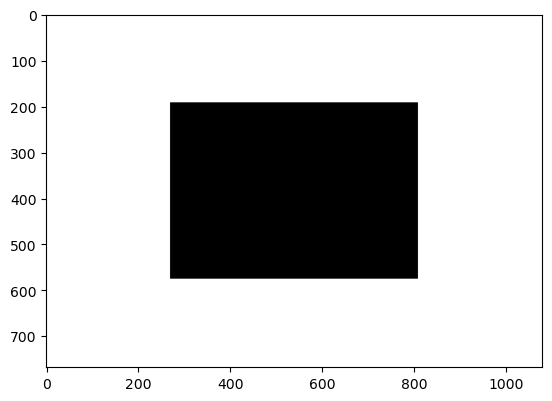

In [113]:
plt.imshow(mask, cmap='Grays');

Multiplying elementwise with the mask will retain only the pixe in the center of the images.

In [114]:
def mask_for(images, mask):
    new_images = np.empty_like(images)
    nr_images = images.shape[0]
    for image_nr in range(nr_images):
        new_images[image_nr, :, :] = mask*images[image_nr, :, :]
    return new_images

In [115]:
%timeit mask_for(images, mask)

579 ms ± 36.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Again, this can be done by broadcasting as well.  You can broadcast along axis 0.

In [116]:
def mask_broadcast(images, mask):
    return images*mask

In [117]:
%timeit mask_broadcast(images, mask)

484 ms ± 58.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Again, broadcasting is faster, but by less than 10 %.

In [118]:
np.allclose(mask_for(images, mask), mask_broadcast(images, mask))

True

### Darken the upper and lower edge of all the images.

You could implement this by creating a mask, but since you already did that, it nicer to try something else.  If you had just a single image, you could create an one-dimensional array with the appropriate scale factor to reduce the brightness of each row.

In [119]:
nr_images, height, _ = images.shape

In [120]:
height_scale = 0.5*(1.0 + np.cos(np.linspace(-np.pi, np.pi, height)))

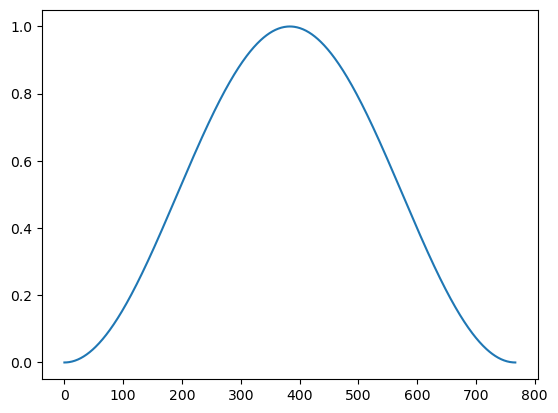

In [121]:
plt.plot(np.arange(height), height_scale);

Now you can create such a height scale for each image, so this will be a $P \times M$ array.

In [122]:
height_scales = np.transpose(np.repeat(height_scale, repeats=nr_images).reshape((height, -1)))

In [123]:
height_scales.shape

(200, 768)

All rows in this two-dimensional array should be equal.

In [124]:
np.allclose(height_scales[0, :], height_scales[-1, :])

True

However, you want a different scaling for each image, the first should be the darkest, the last the lightest.

In [125]:
brightness_scale = np.linspace(0.5, 1.0, nr_images)

Now you can broadcast `brightness_scale` over axis 0 of `height_scales` to modify the latter for each image.

In [126]:
height_scales *= brightness_scale[:, None]

Now the height scale of the first and the last image can be compared visually.

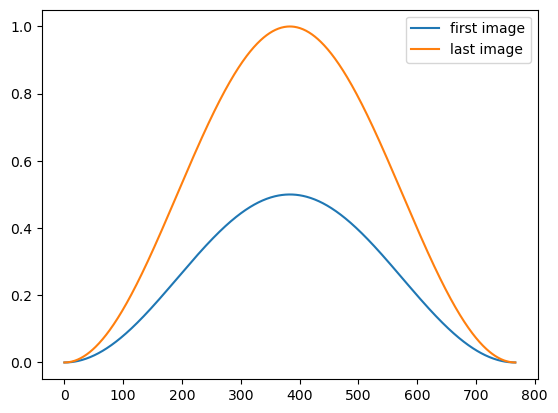

In [127]:
plt.plot(np.arange(height), height_scales[0, :], label='first image')
plt.plot(np.arange(height), height_scales[-1, :], label='last image')
plt.legend();

Indeed, the first iamge will be the darkest, the last the lightest.

In [128]:
def darken_top_bottom_for(images, height_scales):
    new_images = np.empty_like(images)
    width = images.shape[2]
    for column in range(width):
        new_images[:, :, column] = images[:, :, column]*height_scales
    return new_images

In [129]:
%timeit darken_top_bottom_for(images, height_scales)

6.55 s ± 243 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [130]:
def darken_top_bottom_broadcast(images, height_scales):
    return images*height_scales[:, :, None]

In [131]:
%timeit darken_top_bottom_broadcast(images, height_scales)

479 ms ± 81.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This time, the difference is quite large, broadcasting is almost a factor 10 faster.  Also note that this approach is slightly faster than applying a mask.

In [132]:
np.allclose(
    darken_top_bottom_for(images, height_scales),
    darken_top_bottom_broadcast(images, height_scales)
)

True

Just for fun, you can also compare it to the truly pedestrian approach.

In [133]:
def darken_top_bottom_pedestrian(images, height_scale, brightness_scale):
    new_images = np.empty_like(images)
    nr_images, height, width = images.shape
    for image_nr in range(nr_images):
        for column in range(width):
            new_images[image_nr, :, column] = \
                images[image_nr, :, column]*height_scale*brightness_scale[image_nr]
    return new_images

In [134]:
%timeit darken_top_bottom_pedestrian(images, height_scale, brightness_scale)

1.99 s ± 76.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Interestingly, it is faster than the single `for` loop approach, but still slower by far when compared to the broadcasting approach.

In [135]:
np.allclose(
    darken_top_bottom_pedestrian(images, height_scale, brightness_scale),
    darken_top_bottom_broadcast(images, height_scales)
)

True

### Darken the left and right edge of all the images.

This task is of course very similar to the previous one

In [136]:
nr_images, _, width = images.shape

In [137]:
width_scale = 0.5*(1.0 + np.cos(np.linspace(-np.pi, np.pi, width)))

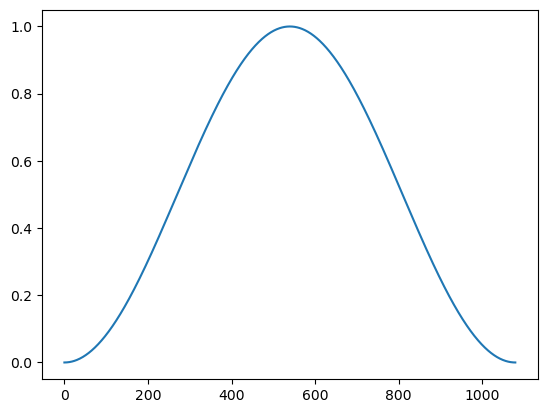

In [138]:
plt.plot(np.arange(width), width_scale);

In [139]:
width_scales = np.transpose(np.repeat(width_scale, repeats=nr_images).reshape((width, -1)))

In [140]:
width_scales.shape

(200, 1080)

The brightness transformation can also be visualized as a heatmap to verify that the first image will be the darkest, and the last the lightest.

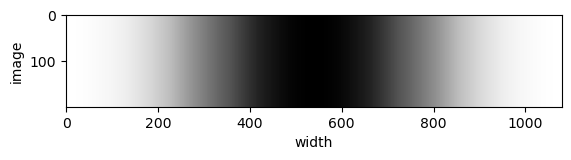

In [141]:
plt.imshow(width_scales, cmap='Greys')
plt.xlabel('width')
plt.ylabel('image');

In [142]:
def darken_left_right_for(images, width_scales):
    new_images = np.empty_like(images)
    height = images.shape[1]
    for row in range(height):
        new_images[:, row, :] = images[:, row, :]*width_scales
    return new_images

In [143]:
%timeit darken_left_right_for(images, width_scales)

789 ms ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [144]:
def darken_left_right_broadcast(images, width_scales):
    return images*width_scales[:, None, :]

In [145]:
%timeit darken_left_right_broadcast(images, width_scales)

573 ms ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Again, the broadcast version is faster, although not by as much as in the previous case.

In [146]:
np.allclose(
    darken_left_right_for(images, width_scales),
    darken_left_right_broadcast(images, width_scales)
)

True

Again, we can compare with the naive implementation.

In [147]:
def darken_left_right_pedestrian(images, width_scale, brightness_scale):
    new_images = np.empty_like(images)
    nr_images, height, _ = images.shape
    for image_nr in range(nr_images):
        for row in range(height):
            new_images[image_nr, row, :] = \
                images[image_nr, row, :]*width_scale*brightness_scale[image_nr]
    return new_images

In [148]:
%timeit darken_left_right_pedestrian(images, width_scale, brightness_scale)

968 ms ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Interestingly, it is faster than the single `for` loop approach, but still slower by far when compared to the broadcasting approach.

In [149]:
np.allclose(
    darken_left_right_pedestrian(images, width_scale, brightness_scale),
    darken_left_right_broadcast(images, width_scales)
)

False

## Discussion

In all of the four scenarios considered, broadcasting alays had a better performance than `for` loops.  It is also intereesting to notice that although the four scenarios are different, each of them does the exact same number of computations.  This illustrates that the order in which elements of multi-dimensional arrays are accessed si quite important.

It pays of the consider this when designing your software, since making changes to the data representation may become quite costly later in the software development process.

Also note that the operations we implemented in the use cases should be done using optimized libraries such as, e.g., OpenCV.